In [71]:
import numpy as np
import pandas as pd
import os
from os.path import isdir, exists, dirname, join
import matplotlib.pyplot as plt

def get_binned_testset(df, col='age', num_bins=5):
    quantiles = np.linspace(0, 100, num_bins + 1)
    bin_edges = np.percentile(df[col].values, quantiles)
    bin_labels = [f"[{int(bin_edges[i]+0.5)}-{int(bin_edges[i+1]+0.5)}]" for i in range(len(bin_edges)-1)]
    bin_labels[0] = "<" + bin_labels[1].split("-")[0][1:]
    bin_labels[-1] = bin_labels[-2].split("-")[1][:-1] + "+"
    print("bins: ", bin_labels)
    df[col+"_bin"] = pd.cut(df[col], bin_edges, labels=[x for x in range(len(bin_labels))])
    test_df = df[df['strat_fold'] == 10]
    return test_df, bin_labels

def shift_testset(test_df, threshold, col='age'):
    dfcopy = test_df.copy()
    high_df =  dfcopy[dfcopy[col] > threshold]
    low_df  =  dfcopy[dfcopy[col] <= threshold]
    
    hlen = len(high_df)
    llen = len(low_df)
    
    if hlen < 9*llen:
        num_high = hlen 
        num_low = hlen//9
    else:
        num_high = 9*llen 
        num_low = llen
    
    # Sample 90% from high SNR and 10% from low SNR
    high_sample = high_df.sample(n=num_high)
    low_sample = low_df.sample(n=num_low)
        
    shifted_df = pd.concat([high_sample, low_sample])
    return shifted_df 

def check(shifted_testsets, thresholds, col='age'):
    '''
    perform sanity check; print subset sizes and check that subsets were correctly sampled
    '''
    def sanity_check(shifted_testset, col='age', threshold=40):
        num_high = (shifted_testset[col]> threshold).sum()
        num_low  = (shifted_testset[col]<= threshold).sum()
        p  = (100*num_high/(num_high+num_low))
        print(f"Percentage of people with {col} {threshold}+: {p:.2f}%")

    _ = [print(f"Size of dataset with patients with {col} {th}+: {len(x[0])}") for x, th in zip(shifted_testsets.values(), thresholds)]
    _ = [sanity_check(shifted_testset[0], col=col, threshold=th) for shifted_testset, th in zip(shifted_testsets.values(), thresholds)]

def calculate_label_percentage(df, label, col='age', y_v=True, num_bins=4):
    label_mask = df['label_diag_superclass'].str.contains(label)

    if y_v is False:
        return label_mask.mean()
    
    percentages = []
    for bin_num in range(num_bins):
        bin_mask = df[col+'_bin'] == bin_num
        label_count = (label_mask & bin_mask).sum()
        total_patients = bin_mask.sum()
        percentage = label_count / total_patients if total_patients > 0 else 0
        percentages.append(percentage)
    return percentages

def calculate_label_percentage_mean_std(dfs, label, col='age', y_v=True, num_bins=4):
    if y_v is False:
        ps = [calculate_label_percentage(df, label, col=col, y_v=y_v) for df in dfs]
        return np.mean(ps), np.std(ps)
    
    all_percentages = np.zeros((num_bins, len(dfs)))
    for j, df in enumerate(dfs):
        label_mask = df['label_diag_superclass'].str.contains(label)
        for bin_num in range(num_bins):
            bin_mask = df[col+'_bin'] == bin_num
            label_count = (label_mask & bin_mask).sum()
            total_patients = bin_mask.sum()
            all_percentages[bin_num, j] = label_count / total_patients if total_patients > 0 else 0

    mean_percentages = np.mean(all_percentages, axis=1)
    std_percentages = np.std(all_percentages, axis=1)
    return mean_percentages, std_percentages

def get_params(col='snr', num_bins=4, num_shifts=5, num_evals=5, thresholds=None):
    test_df, bin_labels = get_binned_testset(df, num_bins=num_bins, col=col)
    if thresholds is None:
        quantiles = np.linspace(25, 75, num_shifts)
        thresholds = np.percentile(test_df[col].values, quantiles)
    shifted_testsets = {i+1: [shift_testset(test_df, threshold, col=col) for j in range(num_evals)] 
                    for i, threshold in enumerate(thresholds)}
    check(shifted_testsets, thresholds, col=col)
    return test_df, shifted_testsets, bin_labels, thresholds

def plot_bars_y_given_v(test_df, shifted_testsets, labels, xtick_labels, thresholds, column='age', num_bins=4):
    eval_groups = ['original'] + [f"90% {int(x)}+" for x in thresholds]
    fontsize=12
    fig, axs = plt.subplots(2, 2, figsize=(15, 6))

    for i, label in enumerate(labels):
        row = i // 2
        col = i % 2
        for j in range(len(shifted_testsets.keys())+1):
            if j == 0:
                df = test_df
                mean_percentages = calculate_label_percentage(df, label, col=column, num_bins=num_bins)
                std_percentages = np.zeros(len(mean_percentages))
            else:
                df = shifted_testsets[j]
                mean_percentages, std_percentages = calculate_label_percentage_mean_std(df, label, col=column, num_bins=num_bins)
            axs[row, col].bar(np.arange(len(mean_percentages)) + j * (0.9/len(eval_groups)), mean_percentages, yerr=std_percentages, width=0.15, label=f'{eval_groups[j]}')

        axs[row, col].set_title(label, fontsize=fontsize)
        axs[row, col].set_xticks(np.arange(num_bins) + 0.3)
        axs[row, col].set_xticklabels(xtick_labels, fontsize=fontsize)
        axs[row, col].set_xlabel('V', fontsize=fontsize)
        axs[row, col].set_ylabel('P(Y|V)', fontsize=fontsize)
        axs[row, col].tick_params(axis='both', which='major', labelsize=fontsize)

    # Put a legend below current axis
    fig.legend([f'{eval_groups[j]}' for j in range(len(shifted_testsets)+1)], 
           loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=len(eval_groups), fontsize=fontsize)

    plt.tight_layout()#(rect=[0, 0.03, 1, 0.95])

def plot_bars_y(test_df, shifted_testsets, labels, xtick_labels, thresholds, column='age', num_bins=4):
    eval_groups = ['original'] + [f"90% {int(x)}+" for x in thresholds]
    fontsize=12
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    colormap = plt.cm.viridis

    # Generate colors from the colormap
    colors = [colormap(i) for i in np.linspace(0, 1, len(eval_groups))]

    for i, label in enumerate(labels):
        row = i // 2
        col = i % 2
        mean_percentages = []
        std_percentages = []
        for j in range(len(shifted_testsets.keys())+1):
            if j == 0:
                df = test_df
                mean_percentage = calculate_label_percentage(df, label, col=column, y_v=False, num_bins=num_bins)
                std_percentage = 0
            else:
                df = shifted_testsets[j]
                mean_percentage, std_percentage = calculate_label_percentage_mean_std(df, label, col=column, y_v=False, num_bins=num_bins)
            mean_percentages.append(mean_percentage)
            std_percentages.append(std_percentage)
            
        axs[row, col].bar(np.arange(len(mean_percentages)), mean_percentages, yerr=std_percentages, color=colors)#, width=0.15)#, label=f'{eval_groups[j]}')
        axs[row, col].set_title(label, fontsize=fontsize)
        axs[row, col].set_xticks(np.arange(len(mean_percentages)))
        axs[row, col].set_xticklabels(eval_groups, fontsize=fontsize)
        axs[row, col].set_xlabel('V', fontsize=fontsize)
        axs[row, col].set_ylabel('P(Y)', fontsize=fontsize)
        axs[row, col].tick_params(axis='both', which='major', labelsize=fontsize)

    plt.tight_layout()#(rect=[0, 0.03, 1, 0.95])
    
def perform_analysis(col='age', num_bins=4, num_shifts=5, num_evals=5, thresholds=None):
    '''
    reproduces the plots from the appendix of the paper
    col: defines V, can be e.g. 'age' or 'snr', but also any column of the feature dataset
    thresholds: defines thresholds for the shifts; if you dont specify, it chooses num_shifts equally spaced
                between 25% and 75% percentile
    '''
    test_df, shifted_testsets, bin_labels, thresholds = \
    get_params(col=col, num_bins=num_bins, num_shifts=num_shifts, num_evals=num_evals, thresholds=thresholds)
    plot_bars_y_given_v(test_df, shifted_testsets, labels, bin_labels, thresholds, column=col, num_bins=num_bins)
    plot_bars_y(test_df, shifted_testsets, labels, bin_labels, thresholds, column=col, num_bins=num_bins)
    return test_df, shifted_testsets, bin_labels, thresholds

In [14]:
df = pd.read_csv('data/df.csv')
features = pd.read_csv('data/features.csv')
features = features.fillna(features.median())
df = pd.merge(df, features, on="ecg_id", how='inner')
labels = ['CD', 'MI', 'STTC', 'HYP']

bins:  ['<50', '[50-62]', '[62-72]', '72+']
Size of dataset with patients with age 40+: 2097
Size of dataset with patients with age 50+: 1822
Size of dataset with patients with age 60+: 1367
Size of dataset with patients with age 70+: 824
Size of dataset with patients with age 80+: 343
Percentage of people with age 40+: 90.03%
Percentage of people with age 50+: 90.01%
Percentage of people with age 60+: 90.05%
Percentage of people with age 70+: 90.05%
Percentage of people with age 80+: 90.09%


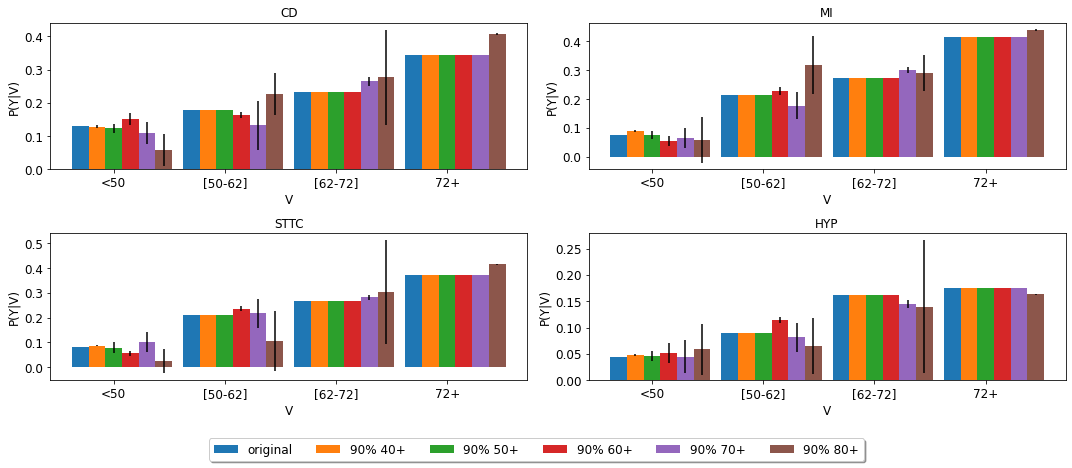

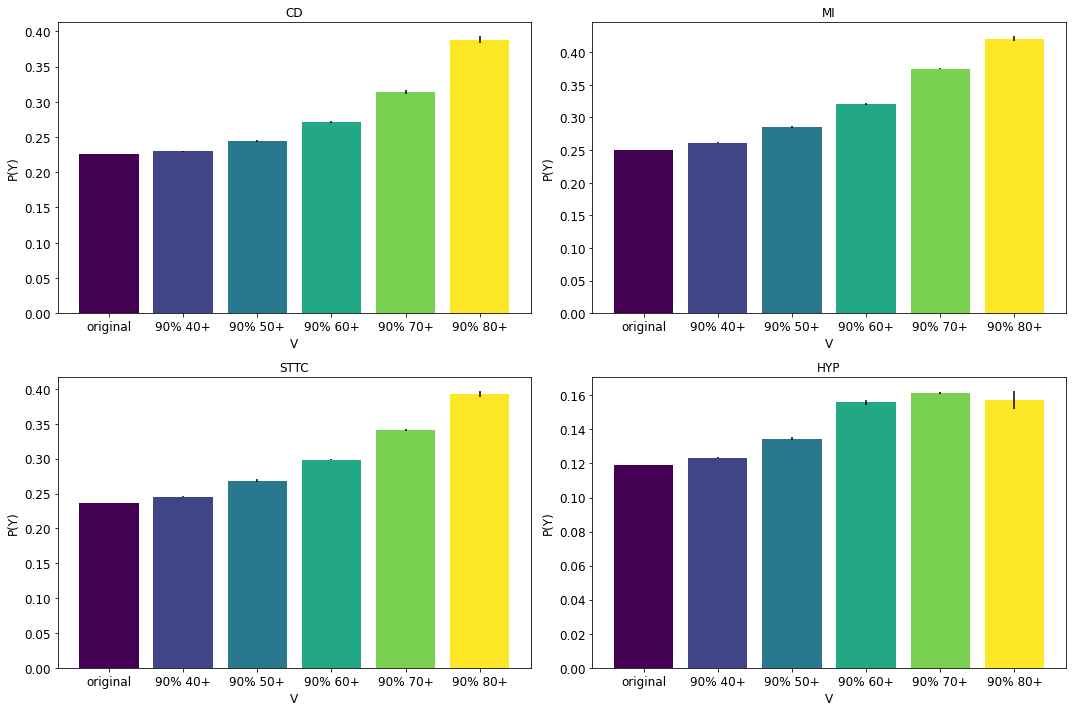

In [73]:
test_df, shifted_testsets, bin_labels, thresholds = perform_analysis(col='age', \
                                num_bins=4, num_shifts=5, num_evals=5, thresholds=[40, 50, 60, 70, 80])

bins:  ['<18', '[18-26]', '[26-35]', '35+']
Size of dataset with patients with snr 15.4452725+: 1831
Size of dataset with patients with snr 20.67893575+: 1424
Size of dataset with patients with snr 24.980424166666666+: 1017
Size of dataset with patients with snr 29.5312445+: 611
Percentage of people with snr 15.4452725+: 90.01%
Percentage of people with snr 20.67893575+: 90.03%
Percentage of people with snr 24.980424166666666+: 90.07%
Percentage of people with snr 29.5312445+: 90.02%


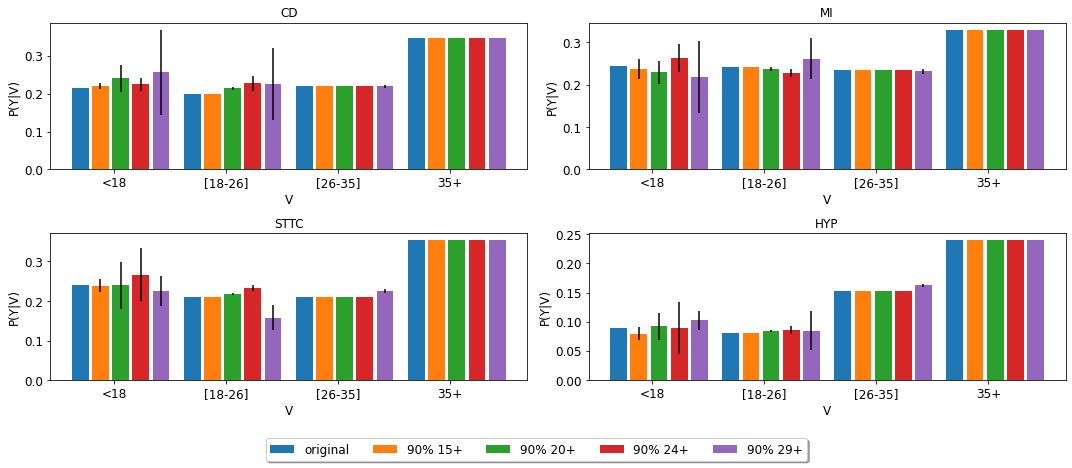

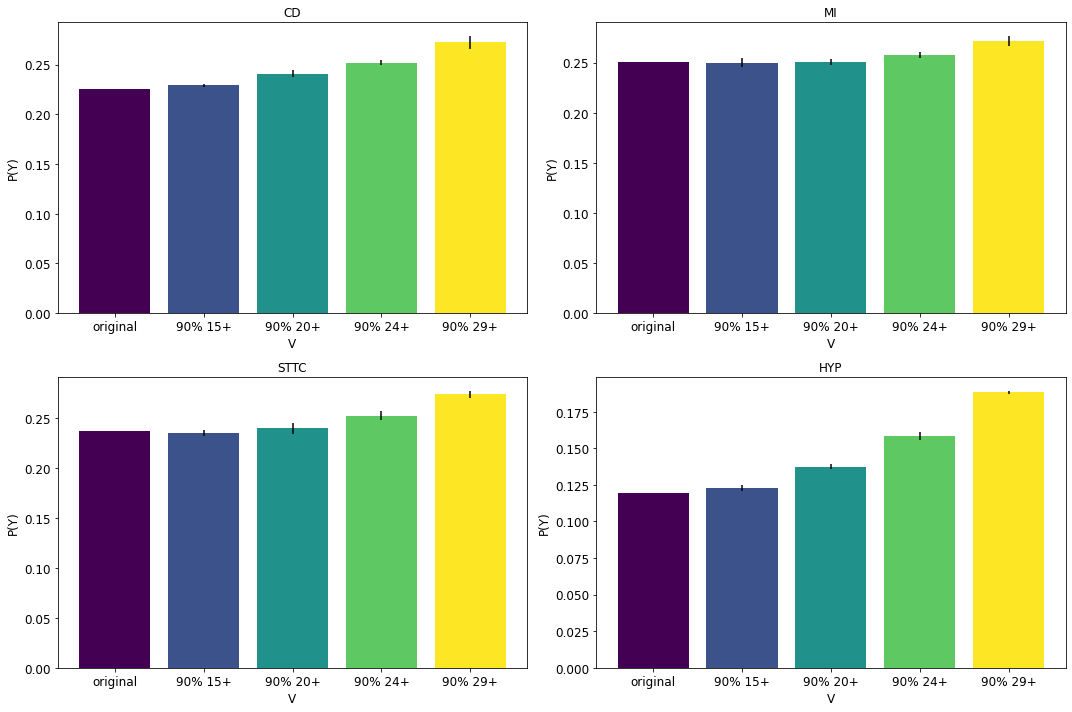

In [74]:
_ = perform_analysis(col='snr', num_bins=4, num_shifts=4, num_evals=5)

bins:  ['<88', '[88-96]', '[96-104]', '104+']
Size of dataset with patients with QRS_Dur_Global 88.0+: 1707
Size of dataset with patients with QRS_Dur_Global 90.0+: 1516
Size of dataset with patients with QRS_Dur_Global 94.0+: 1175
Size of dataset with patients with QRS_Dur_Global 98.0+: 905
Size of dataset with patients with QRS_Dur_Global 104.0+: 548
Percentage of people with QRS_Dur_Global 88.0+: 90.04%
Percentage of people with QRS_Dur_Global 90.0+: 90.04%
Percentage of people with QRS_Dur_Global 94.0+: 90.04%
Percentage of people with QRS_Dur_Global 98.0+: 90.06%
Percentage of people with QRS_Dur_Global 104.0+: 90.15%


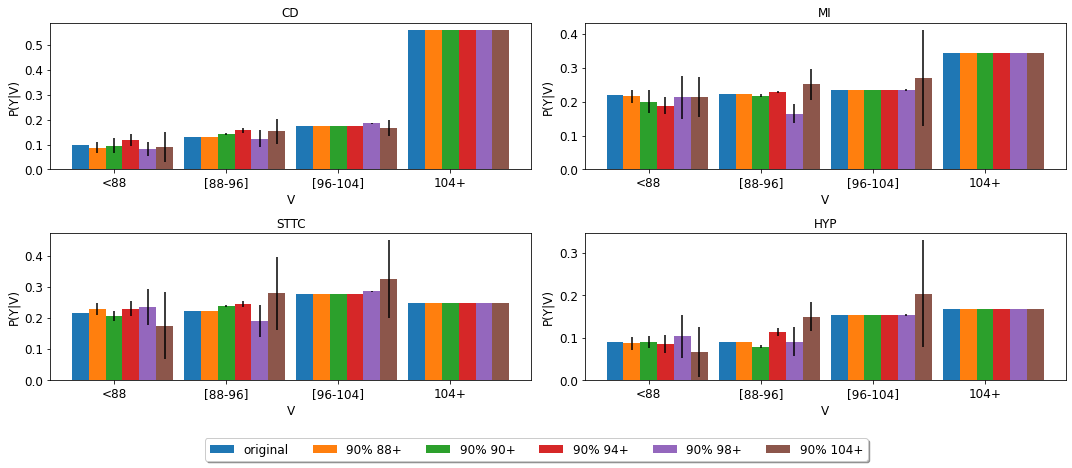

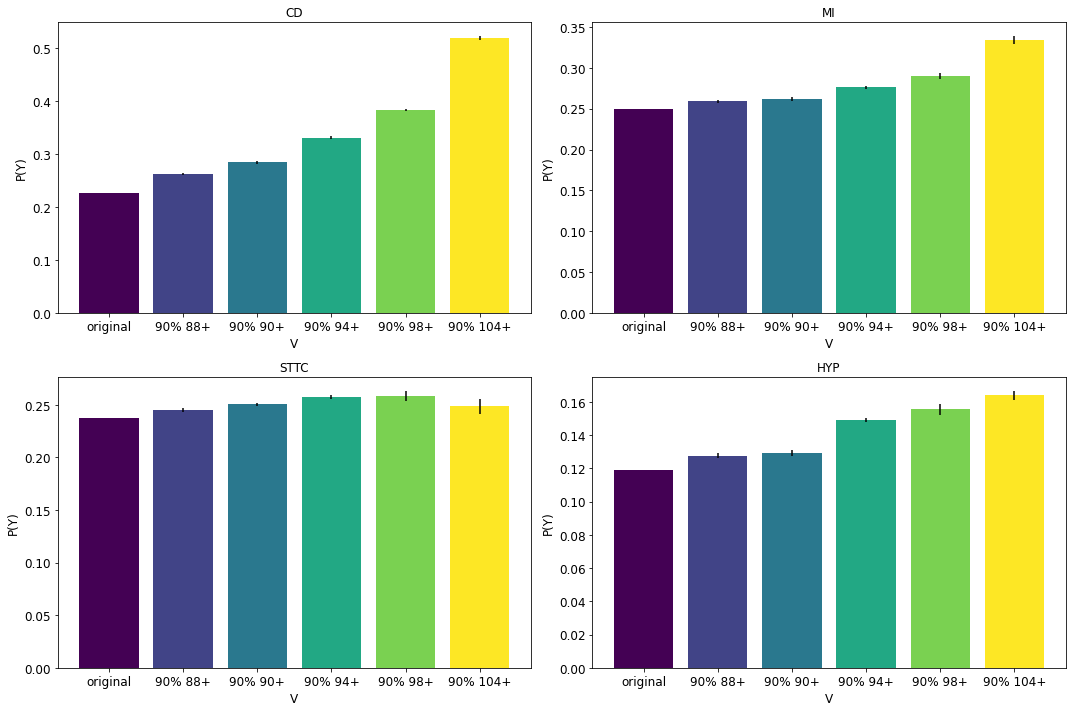

In [76]:
_ = perform_analysis(col='QRS_Dur_Global', num_bins=4, num_shifts=5, num_evals=5, thresholds=None)